
参考: 
https://blog.csdn.net/qq_44951759/article/details/119915703

### ARIMA模型

#### 1. 数据平稳性与差分法
ARIMA模型=AR+I+MA，应用：如现在拿到股票数据，根据其历史变化情况预测其未来变化。
拿到的数据可能千奇百怪，需要有迹可循才能预测，因此要求这些序列有惯性。

平稳性：
- 平稳性就是要求经由样本时间序列所得到的拟合曲线在未来的一段期间内仍能顺着现有的形态“惯性”地延续下去
- 平稳性要求序列的均值和方差不发生明显变化

严平稳与弱平稳：
- 严平稳：严平稳表示的分布不随时间的改变而改变。如:白噪声(正态), 无论怎么取, 都是期望为0， 方差为1 
- 弱平稳：期望与相关系数（依赖性）不变 未来某时刻的t的值Xt就要依赖于它过去的信息，所以需要依赖性

数据浮动太大了，为了让数据变得稳定，采用: 差分法， 二阶差分就是对一阶差分做差分

差分法:  时间序列在t与t-1时刻的差值 

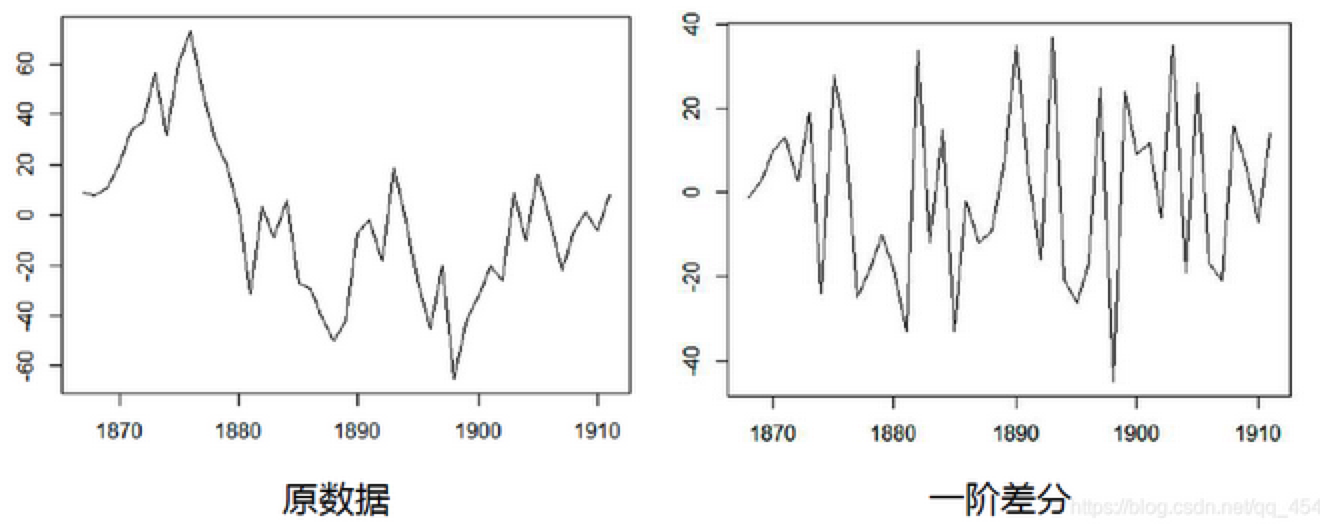

In [1]:
import pandas as pd 
import numpy as np 
import statsmodels # 时间序列
import seaborn as sns 
import matplotlib.pylab as plb 
from scipy import stats 
import matplotlib.pyplot as plt 

# 2.数据预处理

            UMCSENT
DATE               
2000-01-01    112.0
2000-02-01    111.3
2000-03-01    107.1
2000-04-01    109.2
2000-05-01    110.7


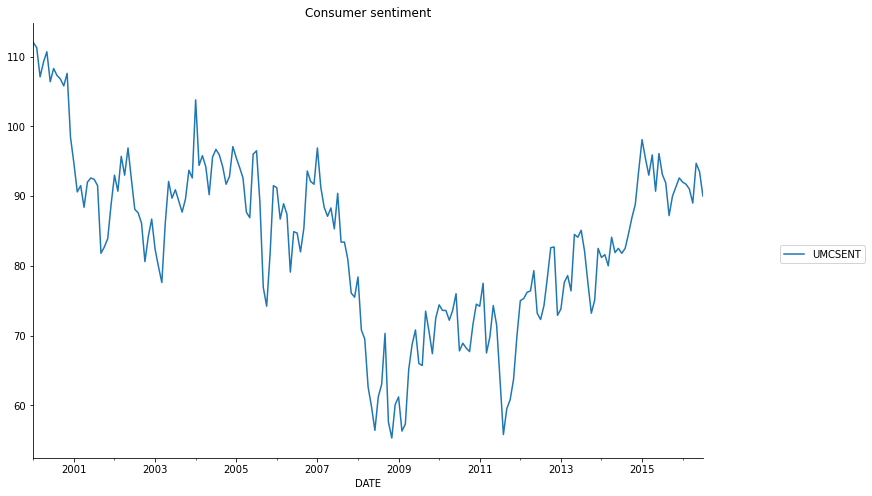

In [21]:
sentiment = pd.read_csv('./confidence美国消费者信心指数sentiment.csv',index_col='DATE',parse_dates=['DATE'])
# index_col=0, parse_dates=[0]
print(sentiment.head())
#切分为测试数据和训练数据
n_sample = sentiment.shape[0]
n_train = int(0.95*n_sample)+1
n_forecast = n_sample - n_train 
ts_train = sentiment.iloc[:n_train]['UMCSENT']
ts_test = sentiment.iloc[:n_forecast]['UMCSENT']

sentiment_short = sentiment.loc['2000':'2017']
sentiment_short.plot(figsize=(12,8))
plt.title('Consumer sentiment')
plt.legend(bbox_to_anchor=(1.25,0.5))
sns.despine()
plt.show()



### 3.时间序列的差分d-将序列平稳化

<ipython-input-22-fcd3320dbb95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
<ipython-input-22-fcd3320dbb95>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)


array([<AxesSubplot:xlabel='DATE'>, <AxesSubplot:xlabel='DATE'>,
       <AxesSubplot:xlabel='DATE'>], dtype=object)

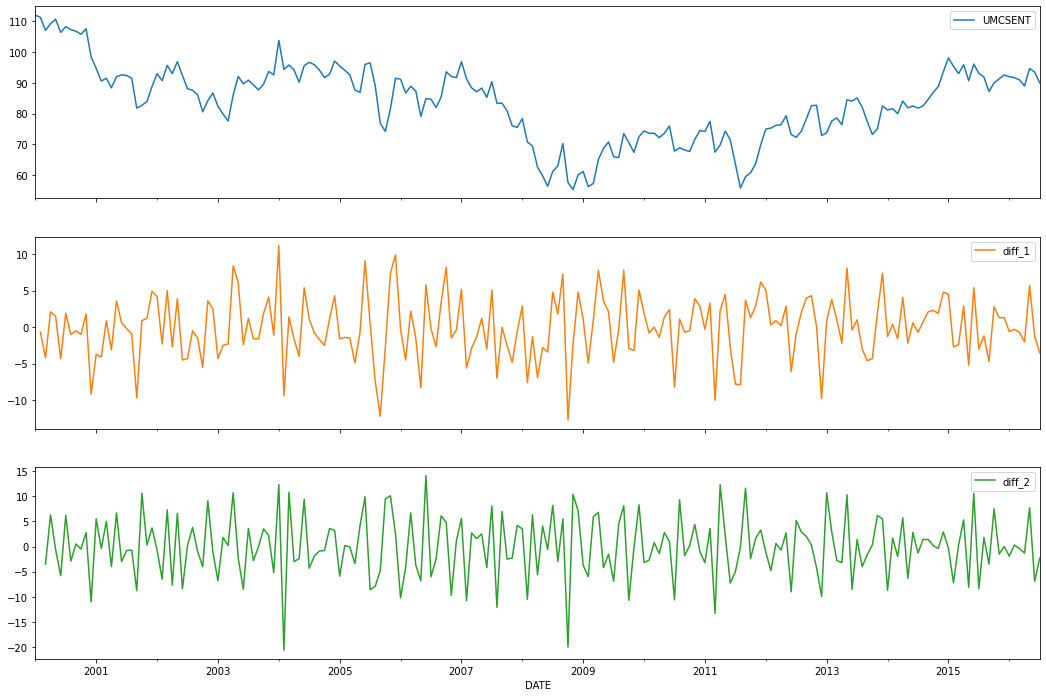

In [22]:
# 时间序列的差分d-将序列平稳化
sentiment_short['diff_1'] = sentiment_short['UMCSENT'].diff(1)
# 1个时间间隔，一阶差分，再一次是二阶差分
sentiment_short['diff_2'] = sentiment_short['diff_1'].diff(1)
sentiment_short.plot(subplots=True, figsize=(18,12))


### ARIMA 模型原理
自回归模型AR 

描述当前值与历史值之间的关系，用变量自身的历史时间数据对自身进行预测

自回归模型必须满足平稳性的要求

p阶自回归过程的公式定义：

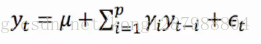

yt是当前值 u是常数项 P是阶数 ri是自相关系数 et是误差

（P当前值距p天前的值的关系）

自回归模型的限制

1、自回归模型是用自身的数据进行预测

2、必须具有平稳性

3、必须具有相关性，如果自相关系数（φi）小于0.5，则不宜采用

4、自回归只适用于预测与自身前期相关的现象

移动平均模型MA

移动平均模型关注的是自回归模型中的误差项的累加
q阶自回归过程的公式定义：


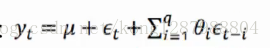

移动平均法能有效地消除预测中的随机波动
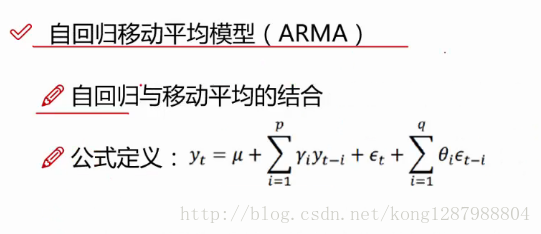

I是差分模型

需要确定P和Q，

d是做几阶差分,一般1阶就可以了
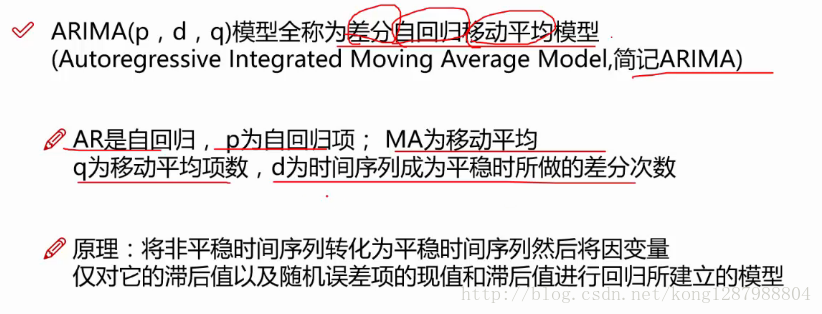

#### 选择P与Q的方法
自相关函数ACF（autocorrelation function）

有序的随机变量序列与其自身相比较自相关函数反映了同一序列在不同时序的取值的相关性
公式：
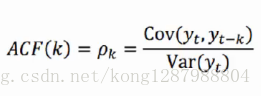
变量与自身的变化，yt和yt-1到yt和yt-k的相关系数

k阶滞后点

Pk的取值范围【-1，1】
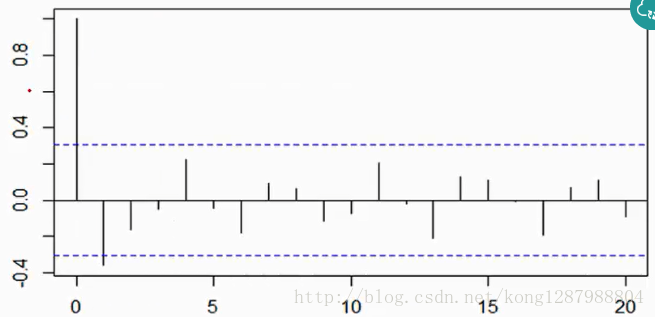
虚线表示95%，置信区间

偏自相关函数（PACF）（partial autocorrelation function）
- 1、对于一个平稳AR（p）模型，求出滞后k自相关系数p（k）时
实际上得到的并不是x（t）与x（t-k）之间单纯的相关关系
- 2、x（t）同时还会受到中间k-1个随机变量x（t-1）、x（t-2）……、x（t-k+1）的影响，而这k-1个随机变量又都和x（t-k）具有相关关系，所以自相关系数p（k）里实际掺杂了其他变量对x（t）与x（t-k）的影响
- 3、剔除了中间k-1个随机变量x（t-1）、x（t-2）、……、x（t-k+1）的干扰之后
x（t-k）对x（t）影响的相关程度
- 4、ACF还包含了其他变量的影响

而偏自相关系数PACF是严格这两个变量之间的相关性


### 4.通过ACF和PACF确定p,q的值
4.1 建立ACF自相关函数和PACF偏自相关函数

注意 建立acf不能和差分同时run 


In [18]:
import statsmodels.api as sm

In [23]:
del sentiment_short['diff_2']
del sentiment_short['diff_1']

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


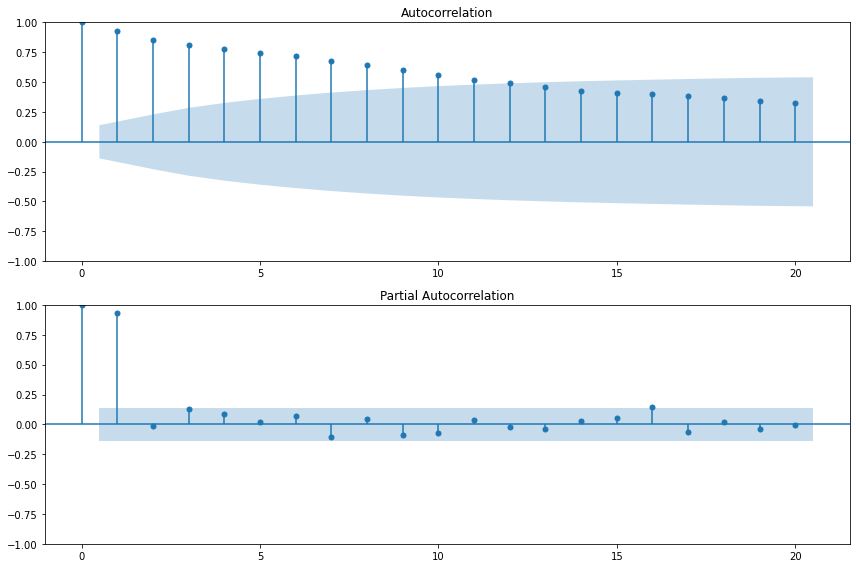

In [24]:
# 3.1 分别画出ACF(自相关)和PACF(偏自相关)图形
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sentiment_short, lags=20, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sentiment_short,lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()


接下来确定ARIMA模型的p、d、q三个参数 ARIMA(p,d,q) 确认方法：
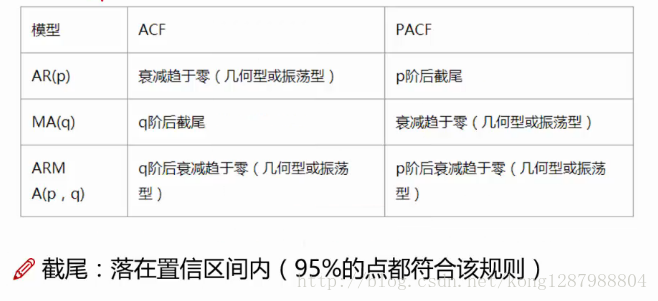
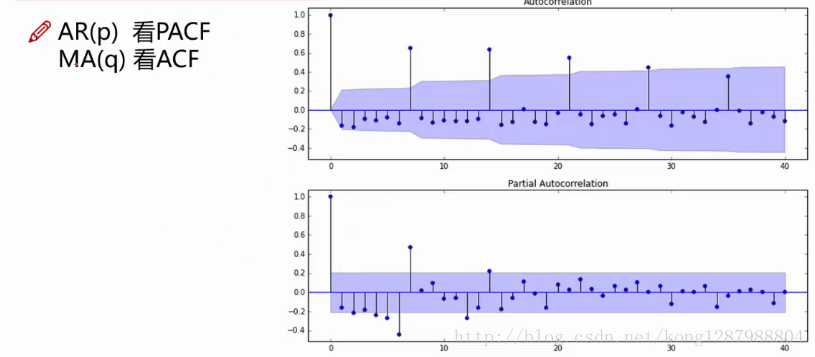

4.2可视化结果：四个图的整合函数，可以改参数直接调用


In [25]:
import statsmodels.tsa.api as smt

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


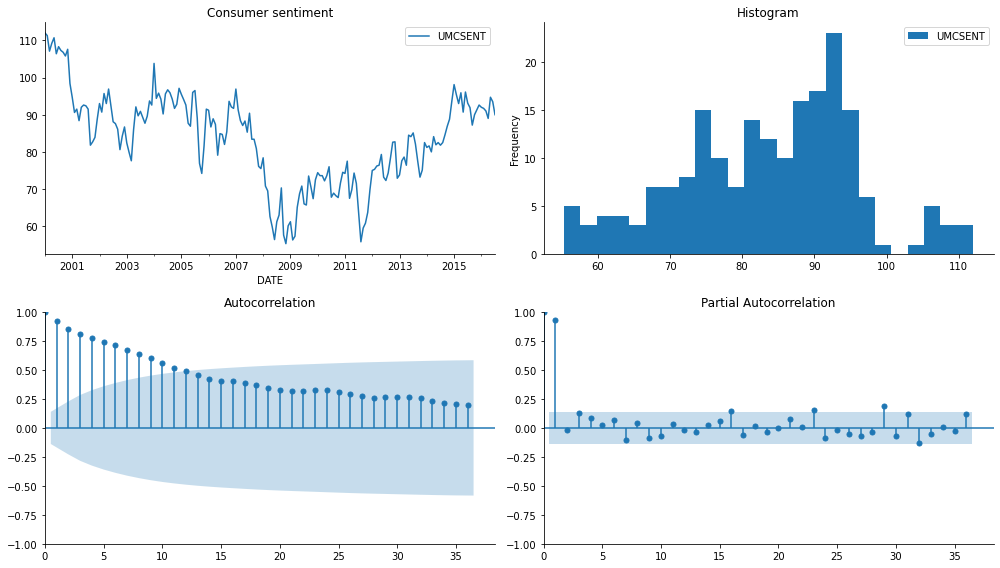

In [27]:
# 3.2 可视化结果
def tsplot(y, lags=None, title='', figsize=(14,8)):
    fig = plt.figure(figsize=figsize)
    layout=(2,2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist',bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine() 
    plt.tight_layout() 
    return ts_ax, acf_ax, pacf_ax

tsplot(sentiment_short, title='Consumer sentiment', lags=36)
plt.show()

### 5.模型建立 - 参数选择
通过导入import itertools 来遍历 p属于[0, 4], q属于[0, 4] d= 0 

In [29]:
# 4. 建立模型--参数选择
arima200 = sm.tsa.ARIMA(ts_train, order=(2,0,0)).fit() # (p,d,q)
# model_results = arima200.fit() 
# 遍历 寻找合适的参数
import itertools 

p_min = 0 
d_min = 0 
q_min = 0 
p_max = 8 
d_max = 0 
q_max = 8 

# Initialize a DataFrame to store the results, 以BIC准则来判断
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min, p_max+1)],columns=['MA{}'.format(i) for i in range(q_min, q_max+1)])

for p,d,q in itertools.product(range(p_min, p_max+1),range(d_min,d_max+1),
                              range(q_min, q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p),'MA{}'.format(q)]=np.nan 
        continue 
    try:
        model=sm.tsa.ARIMA(ts_train, order=(p,d,q),
                          #enforce_stationarity=False,
                          #enforce_invertibility=False,
                          )
        results = model.fit() 
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_r

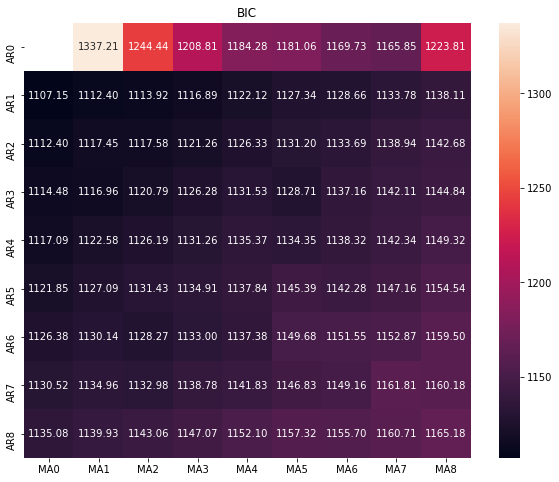

In [30]:
# 画出热度图
fig,ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(results_bic, mask=results_bic.isnull(),
                ax=ax,
                annot=True,
                fmt='.2f')
ax.set_title('BIC')
plt.show()

#### 输出AIC、BIC评价指标

### 模型选择的几种方法：AIC，BIC，HQ准则

选择最优模型的指导思想是从两个方面去考察：一个是似然函数最大化，另一个是模型中的未知参数个数最小化。似然函数值越大说明模型拟合的效果越好，但是我们不能单纯地以拟合精度来衡量模型的优劣，这样回导致模型中未知参数越来越多，模型变得越来越复杂，会造成过拟合。所以一个好的模型应该是拟合精度和未知参数个数的综合最优化配置。

#### AIC准则
AIC准则是由日本统计学家Akaike与1973年提出的，全称是最小化信息量准则（Akaike Information Criterion）。它是拟合精度和参数个数的加权函数：

AIC=2（模型参数的个数）-2ln（模型的极大似然函数）

#### BIC准则
AIC为模型选择提供了有效的规则，但也有不足之处。当样本容量很大时，在AIC准则中拟合误差提供的信息就要受到样本容量的放大，而参数个数的惩罚因子却和样本容量没关系（一直是2），因此当样本容量很大时，使用AIC准则选择的模型不收敛与真实模型，它通常比真实模型所含的未知参数个数要多。BIC（Bayesian InformationCriterion）贝叶斯信息准则是Schwartz在1978年根据Bayes理论提出的判别准则，称为SBC准则(也称BIC)，弥补了AIC的不足。SBC的定义为：

BIC = ln(n)(模型中参数的个数) - 2ln(模型的极大似然函数值)

#### 小结
在进行ARMA参数的选择是，AIC准则和BIC准则的提出可以有效弥补根据自相关图和偏自相关图定阶的主观性，在有限的阶数范围内帮助我们寻找相对最优拟合模型。

AIC=-2 ln(L) + 2 k 中文名字：赤池信息量

BIC=-2 ln(L) + ln(n)*k 中文名字：贝叶斯信息量

HQ=-2 ln(L) + ln(ln(n))*k

其中L是在该模型下的最大似然，n是数据数量，k是模型的变量个数。

即在AIC标准下和BIC标准下取得损失值最小，模型最优。


In [35]:
# 模型评价准则
train_results = sm.tsa.arma_order_select_ic(ts_train, ic=['aic','bic'],trend='c',max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model

AIC (1, 3)
BIC (1, 0)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


结果：

在AIC准则下：AIC（1,3）

在BIC准则下：BIC（1,0）

结果p，q值不一。

不一致需要我们重新审判

6.模型检验

6.1残差检验

主要针对残差进行正态性检验和自相关性检验。

残差满足正态性，主要是为了残差集中于某一个数值，如果该值与0很接近，则它实际服从均值为0的正态分布，即它是一个白噪声。白噪声是指功率谱密度在整个频域内均匀分布的噪声。白噪声或白杂讯，是一种功率频谱密度为常数的随机信号或随机过程。换句话说，此信号在各个频段上的功率是一样的，由于白光是由各种频率（颜色）的单色光混合而成，因而此信号的这种具有平坦功率谱的性质被称作是“白色的”，此信号也因此被称作白噪声。

残差满足非自相关性，主要是为了在残差中不再包括AR或者MA过程产生的序列。
正态性检验可以使用shapiro.test函数来检查，当p-value>0.05时表明满足正态分布，该值越大越好，直到接近于1.

残差的自相关性可以用函数tsdiag(model)来迅速检验。该函数会列出残差的散点图，自相关性acf检验和Box.test的检验值（pvalue大于0.05即满足非自相关性）。

为什么残差要是白噪声？

答：得到白噪声序列，就说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的，残差序列如果通过了白噪声检验，则建模就可以终止了，因为没有信息可以继续提取。如果残差不是白噪声，就说明残差中还有有用的信息，需要修改模型或者进一步提取。


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


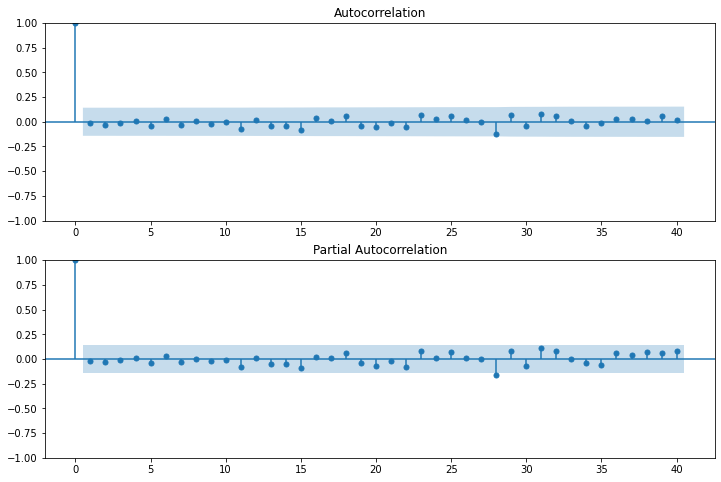

In [38]:
resid = results.resid # 赋值
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

6.2做D-W检验

德宾-沃森（Durbin-Watson）检验。德宾-沃森检验,简称D-W检验，是目前检验自相关性最常用的方法，但它只使用于检验一阶自相关性。因为自相关系数ρ的值介于-1和1之间，所以 0≤DW≤４。

DW＝O＝＞ρ＝１　　 即存在正自相关性

DW＝４＜＝＞ρ＝－１　即存在负自相关性

DW＝２＜＝＞ρ＝０　　即不存在（一阶）自相关性

因此，当DW值显著的接近于O或４时，则存在自相关性，而接近于２时，则不存在（一阶）自相关性。这样只要知道ＤＷ统计量的概率分布，在给定的显著水平下，根据临界值的位置就可以对原假设Ｈ０进行检验。


In [39]:
print(sm.stats.durbin_watson(results.resid.values))

1.8158009071507037


6.3观察是否符合正态分布，QQ图

这里使用QQ图，它用于直观验证一组数据是否来自某个分布，或者验证某两组数据是否来自同一（族）分布。在教学和软件中常用的是检验数据是否来自于正态分布。

In [41]:
from statsmodels.graphics.api import qqplot

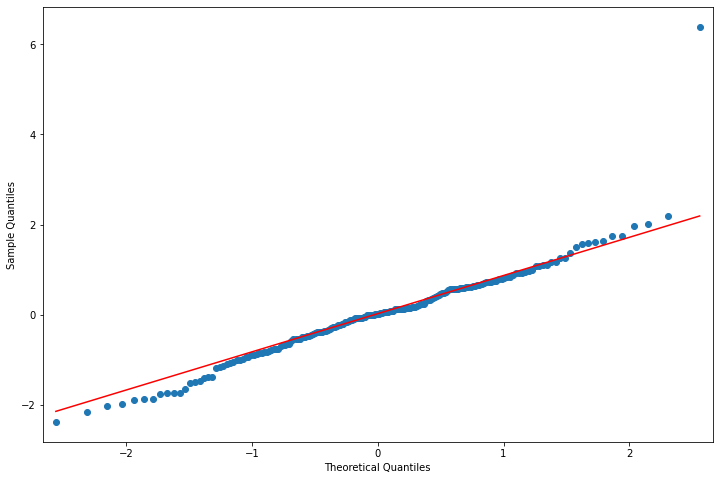

In [42]:
resid = results.resid # 残差
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q',ax=ax, fit=True)

#### 6.4Ljung-Box检验（白噪声检验）

Ljung-Box test是对randomness的检验,或者说是对时间序列是否存在滞后相关的一种统计检验。对于滞后相关的检验，我们常常采用的方法还包括计算ACF和PCAF并观察其图像，但是无论是ACF还是PACF都仅仅考虑是否存在某一特定滞后阶数的相关。LB检验则是基于一系列滞后阶数，判断序列总体的相关性或者说随机性是否存在。

时间序列中一个最基本的模型就是高斯白噪声序列。而对于ARIMA模型，其残差被假定为高斯白噪声序列，所以当我们用ARIMA模型去拟合数据时，拟合后我们要对残差的估计序列进行LB检验，判断其是否是高斯白噪声，如果不是，那么就说明ARIMA模型也许并不是一个适合样本的模型。


In [45]:
r,q,p = sm.tsa.acf(resid.values.squeeze(),qstat=True)
data = np.c_[range(1,23),r[1:],q,p]
table = pd.DataFrame(data, columns=['lag',"AC","Q","Prob(>Q)"])
print(table.set_index('lag'))

            AC         Q  Prob(>Q)
lag                               
1.0  -0.015872  0.048627  0.825470
2.0  -0.027965  0.200381  0.904665
3.0  -0.007634  0.211750  0.975670
4.0   0.007957  0.224168  0.994169
5.0  -0.041057  0.556565  0.989905
6.0   0.028082  0.712913  0.994208
7.0  -0.032097  0.918279  0.996041
8.0   0.003447  0.920661  0.998702
9.0  -0.022044  1.018597  0.999393
10.0 -0.006254  1.026525  0.999806
11.0 -0.073011  2.112883  0.998058
12.0  0.017842  2.178121  0.999080
13.0 -0.043423  2.566737  0.999100
14.0 -0.042673  2.944182  0.999168
15.0 -0.078599  4.232003  0.996873
16.0  0.033716  4.470336  0.997822
17.0  0.007308  4.481597  0.998899
18.0  0.062094  5.299363  0.998312
19.0 -0.039865  5.638396  0.998655
20.0 -0.053168  6.244993  0.998524
21.0 -0.014102  6.287918  0.999174
22.0 -0.054683  6.937215  0.999051


结果分析：原假设为白噪声（相关系数为零）检验的结果就是看最后一列前十二行的检验概率（一般观察滞后1~12阶），如果检验概率小于给定的显著性水平，比如0.05、0.10等就拒绝原假设，即为非白噪声。

就结果来看，如果取显著性水平为0.05或者0.1，结果不小于显著性水平，那么相关系数与零没有显著差异，即为白噪声序列。


### 7.模型预测
模型确定之后，就可以开始进行预测了，我们对未来5年的数据进行预测。

ts_train 从2000-01——2015-10 190个数据

ts_test 从2015-12——2016-07 9个数据

In [48]:
ts_train

DATE
2000-01-01    112.0
2000-02-01    111.3
2000-03-01    107.1
2000-04-01    109.2
2000-05-01    110.7
              ...  
2015-06-01     96.1
2015-07-01     93.1
2015-08-01     91.9
2015-09-01     87.2
2015-10-01     90.0
Name: UMCSENT, Length: 190, dtype: float64

In [49]:
ts_test

DATE
2000-01-01    112.0
2000-02-01    111.3
2000-03-01    107.1
2000-04-01    109.2
2000-05-01    110.7
2000-06-01    106.4
2000-07-01    108.3
2000-08-01    107.3
2000-09-01    106.8
Name: UMCSENT, dtype: float64

In [50]:
n_train

190

In [52]:
n_forecast

9

In [55]:
ts_test = sentiment.iloc[n_train+1:]['UMCSENT']

In [56]:
ts_test

DATE
2015-12-01    92.6
2016-01-01    92.0
2016-02-01    91.7
2016-03-01    91.0
2016-04-01    89.0
2016-05-01    94.7
2016-06-01    93.5
2016-07-01    90.0
Name: UMCSENT, dtype: float64

In [54]:
ts_test

DATE
2000-10-01    105.8
2000-11-01    107.6
2000-12-01     98.4
2001-01-01     94.7
2001-02-01     90.6
              ...  
2016-03-01     91.0
2016-04-01     89.0
2016-05-01     94.7
2016-06-01     93.5
2016-07-01     90.0
Name: UMCSENT, Length: 190, dtype: float64

2015-12-01    89.785400
2016-01-01    89.636096
2016-02-01    89.007459
2016-03-01    87.585499
2016-04-01    87.654404
2016-05-01    87.374770
2016-06-01    86.756694
2016-07-01    86.852496
Freq: MS, Name: predicted_mean, dtype: float64


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


<AxesSubplot:xlabel='DATE'>

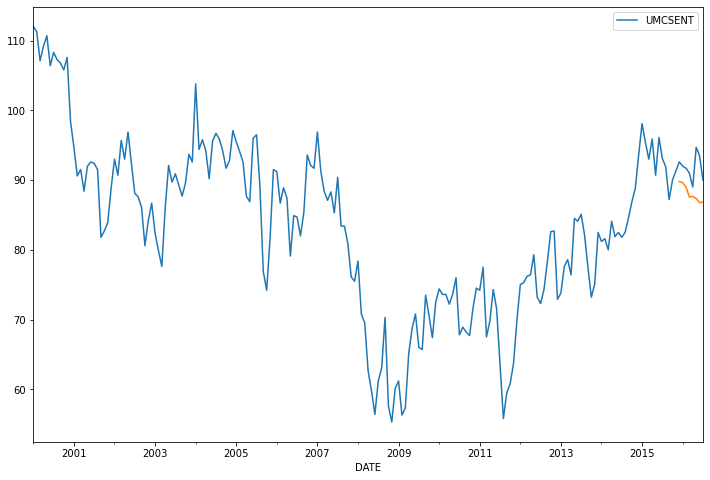

In [62]:
# 模型预测
predict_sunspots = results.predict('2015-12-01','2016-07-01',dynamic=True)
print(predict_sunspots)
fig, ax = plt.subplots(figsize=(12,8))
# ax = sentiment.iloc[:n_train].plot(ax=ax)
ax=sentiment.plot(ax=ax)
predict_sunspots.plot(ax=ax)

###  滑动窗口
假设有一份数据(2016~2017年365天365个点)，现在想了解2016/2/5情况，拿出这个点的数据可对其进行描述，但这样太绝对有误差，可以拿2.1-2.10的数据取平均值来描述。这样更加科学，尤其是在进行预测时。我们可以基于这样一个窗口取平均，使值更加平稳。

**滑动窗口**：指定窗口尺寸，计算时根据待求值对窗口进行单位距离滑动。

In [65]:
# 构造数据
df = pd.Series(np.random.randn(600),index=pd.date_range('7/1/2016',freq='D',periods=600))
print(df.head())
print('--------')
# 构造滑动窗口（指定窗口大小)
r = df.rolling(window=10)
print(r)
print('------')
# 指定窗口计算方式
print(r.mean().head(15)) # 在长度为10的窗口上计算均值


2016-07-01   -1.261492
2016-07-02    1.884532
2016-07-03   -0.059756
2016-07-04    0.525862
2016-07-05   -1.196299
Freq: D, dtype: float64
--------
Rolling [window=10,center=False,axis=0]
------
2016-07-01         NaN
2016-07-02         NaN
2016-07-03         NaN
2016-07-04         NaN
2016-07-05         NaN
2016-07-06         NaN
2016-07-07         NaN
2016-07-08         NaN
2016-07-09         NaN
2016-07-10   -0.382082
2016-07-11   -0.259812
2016-07-12   -0.565720
2016-07-13   -0.399345
2016-07-14   -0.442530
2016-07-15   -0.270127
Freq: D, dtype: float64


<AxesSubplot:>

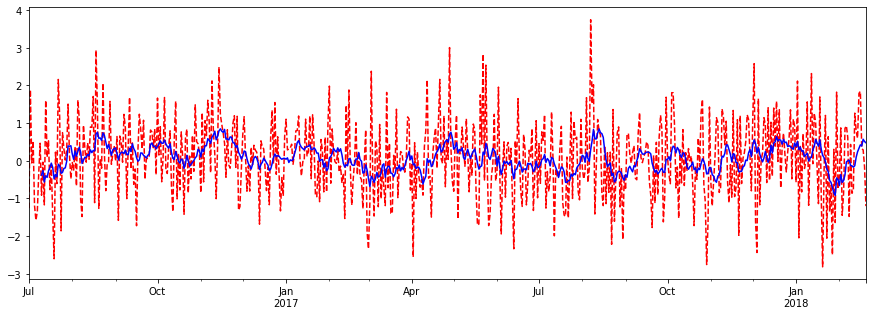

In [66]:
# 可视化效果对比
%matplotlib inline 
import matplotlib.pyplot as plt # 导入模块
plt.figure(figsize=(15,5)) # 指定绘图尺寸
df.plot(style='r--') # 原始数据用红色虚线表示
df.rolling(window=10).mean().plot(style='b') # 窗口滑动计算数据，用蓝色实线展示